<a href="https://colab.research.google.com/github/alfanadhya/acne-detection-with-glcm-and-gabor/blob/main/training_gmm_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# LIBRARIES
from sklearn import preprocessing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

# to split training and test data
from sklearn.model_selection import train_test_split

# to save model
import joblib

In [ ]:
# Load features
feats_path = '/content/drive/MyDrive/DatasetTA_Playground/experiments/features/glcm_features_grayscale.xlsx'
feats_df = pd.read_excel(feats_path)
feats_df.iloc[:,1:].head()

,contrast,dissimilarity,correlation,energy,homogeneity,ASM,label
0,0.020025,0.134799,0.869855,0.030868,0.410748,0.003909,0
1,0.022913,0.148384,0.919504,0.018559,0.369773,0.002143,0
2,0.008061,0.089653,0.979681,0.025450,0.559909,0.003119,0
3,0.043307,0.200334,0.954040,0.008647,0.284268,0.000922,0
4,0.032804,0.171285,0.757786,0.023506,0.345511,0.002819,0


In [ ]:
no_acne_data = feats_df[feats_df.label==0].drop(['Unnamed: 0'], axis=1).to_numpy()
acne_data = feats_df[feats_df.label==1].drop(['Unnamed: 0'], axis=1).to_numpy()
print(len(no_acne_data), len(acne_data))

908 870


In [ ]:
X_train_no_acne, X_test_no_acne, y_train_no_acne, y_test_no_acne = train_test_split(no_acne_data[:,:-1], no_acne_data[:,-1], test_size=0.2, random_state = 42)
X_train_acne, X_test_acne, y_train_acne, y_test_acne = train_test_split(acne_data[:,:-1], acne_data[:,-1], test_size=0.2, random_state = 42)

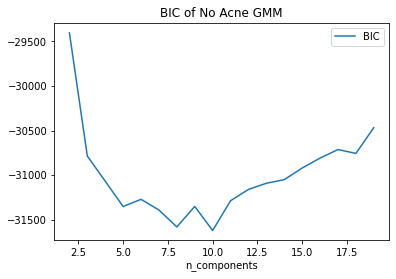

In [ ]:
n_components = np.arange(2, 20)
no_acne_gmm = [GaussianMixture(n, covariance_type='full', random_state=0).fit(X_train_no_acne) for n in n_components]
plt.plot(n_components, [m.bic(no_acne_data[:,:-1]) for m in no_acne_gmm], label='BIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.title('BIC of No Acne GMM')
plt.show()

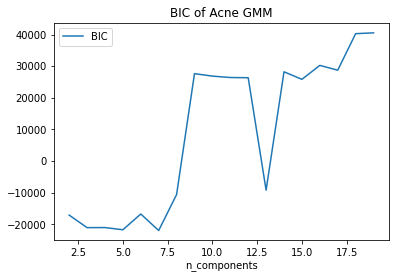

In [ ]:
n_components = np.arange(2, 20)
acne_gmm = [GaussianMixture(n, covariance_type='full', random_state=0).fit(X_train_acne) for n in n_components]
plt.plot(n_components, [m.bic(acne_data[:,:-1]) for m in acne_gmm], label='BIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.title('BIC of Acne GMM')
plt.show()

In [ ]:
best_no_acne_gmm = GaussianMixture(n_components=10, covariance_type='full', random_state=0).fit(X_train_no_acne)
best_acne_gmm = GaussianMixture(n_components=7, covariance_type='full', random_state=0).fit(X_train_acne)

In [ ]:
scores = []
test_concat = np.concatenate((X_test_acne, X_test_no_acne), axis=0)
for i in test_concat:
  proc_image = np.reshape(i, (1, -1))
  no_acne_score = best_no_acne_gmm.score_samples(proc_image)
  acne_score = best_acne_gmm.score_samples(proc_image)
  res = acne_score > no_acne_score
  
  scores.append(res*1)

In [ ]:
sc = np.concatenate(scores)
sc_gt = np.concatenate((y_test_acne, y_test_no_acne), axis=0)

test_acc = np.mean(sc.ravel() == sc_gt.ravel()) * 100
test_acc

95.2247191011236

In [ ]:
# save to file
gmm_name = '/content/drive/MyDrive/DatasetTA_Playground/experiments/gmm_models/gmm_no_acne'

In [ ]:
np.save(gmm_name + '_weights', best_no_acne_gmm.weights_, allow_pickle=False)
np.save(gmm_name + '_means', best_no_acne_gmm.means_, allow_pickle=False)
np.save(gmm_name + '_covariances', best_no_acne_gmm.covariances_, allow_pickle=False)

In [ ]:
# reload
acne_means = np.load(gmm_name + 'gmm_acne_means.npy')
acne_covar = np.load(gmm_name + 'gmm_acne_covariances.npy')
loaded_acne_gmm = GaussianMixture(n_components = len(acne_means), covariance_type='full')
loaded_acne_gmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(acne_covar))
loaded_acne_gmm.weights_ = np.load(gmm_name + 'gmm_acne_weights.npy')
loaded_acne_gmm.means_ = acne_means
loaded_acne_gmm.covariances_ = acne_covar

no_acne_means = np.load(gmm_name + 'gmm_no_acne_means.npy')
no_acne_covar = np.load(gmm_name + 'gmm_no_acne_covariances.npy')
loaded_no_acne_gmm = GaussianMixture(n_components = len(no_acne_means), covariance_type='full')
loaded_no_acne_gmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(no_acne_covar))
loaded_no_acne_gmm.weights_ = np.load(gmm_name + 'gmm_no_acne_weights.npy')
loaded_no_acne_gmm.means_ = no_acne_means
loaded_no_acne_gmm.covariances_ = no_acne_covar

In [ ]:
scores_2 = []
for i in test_concat:
  proc_image = np.reshape(i, (1, -1))
  no_acne_score = loaded_no_acne_gmm.score_samples(proc_image)
  acne_score = loaded_acne_gmm.score_samples(proc_image)
  res = acne_score > no_acne_score
  
  scores_2.append(res*1)

sc_2 = np.concatenate(scores_2)
sc_gt = np.concatenate((y_test_acne, y_test_no_acne), axis=0)

test_acc_2 = np.mean(sc_2.ravel() == sc_gt.ravel()) * 100
test_acc_2

87.64044943820225